# Time Series Analysis of Hipparcos
This time series analysis of Hipparcos data was an attempt at measuring the rotation period of the M-type star GJ 3942.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.timeseries import LombScargle
import lightkurve as lk
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
from scipy.optimize import Bounds

## Rotation Period
Our rotation period used is that of a best-fit frequency, while the recorded rotation period is 16.3 days. This can be found in the reference paper. Within the TESS time series analysis, a best-fit frequency of 15.645898033750315 was found and used. The fonts for plots are also stated here.

Reference Paper: [HADES RV Programme with HARPS-N at TNG VI](https://arxiv.org/pdf/1709.06851.pdf)

In [7]:
rp = 15.7
title_font = 18
label_font = 14
tick_font = 12

# Hipparcos Dataset

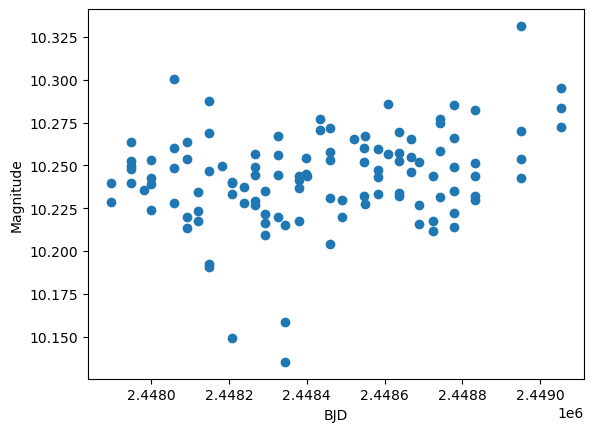

In [8]:
# Scatter plot of sigma-clipped Hipparcos data
Hipp = "/Users/andrewandmatthewfonseca/Downloads/UID_0079126_PLC_001.tbl.txt"
bjd, mag = np.loadtxt(Hipp, skiprows=123, unpack=True, usecols=[0, 1])
std_dev = np.std(mag)
good_data = np.where(np.abs(mag - np.mean(mag)) < 3 * std_dev)[0]
bjd = bjd[good_data]
mag = mag[good_data]
plt.scatter(bjd, mag)
plt.xlabel('BJD')
plt.ylabel('Magnitude')
len(bjd)

# unclipped Hipparcos Data
bjd_full, mag_full = np.loadtxt(Hipp, skiprows=123, unpack=True, usecols=[0, 1])

(array([48., 32.,  2.,  0.,  0.,  0.,  0.,  4., 23.,  5.]),
 array([-1.8452718 , -1.45408204, -1.06289229, -0.67170253, -0.28051277,
         0.11067698,  0.50186674,  0.8930565 ,  1.28424625,  1.67543601,
         2.06662576]),
 <BarContainer object of 10 artists>)

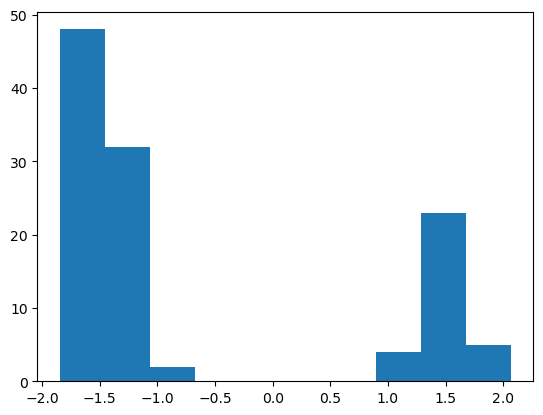

In [9]:
# Histogram of Hipparcos data
dt = np.diff(bjd)
plt.hist(np.log10(dt))

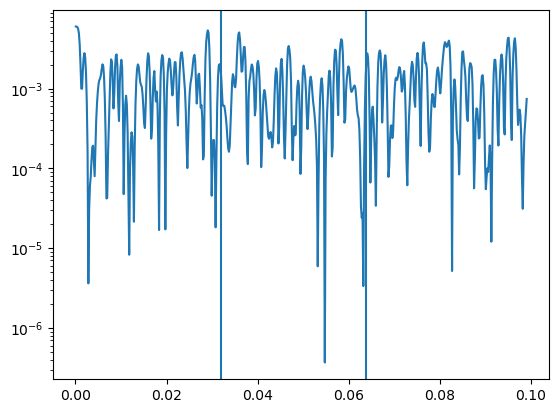

In [10]:
# Lomb-Scargle of Hipparcos data (clipped data)
freq, power = LombScargle(bjd, mag, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(freq, power)
plt.axvline(1/rp)
plt.axvline((1/rp)/2)

(0.1, 100)

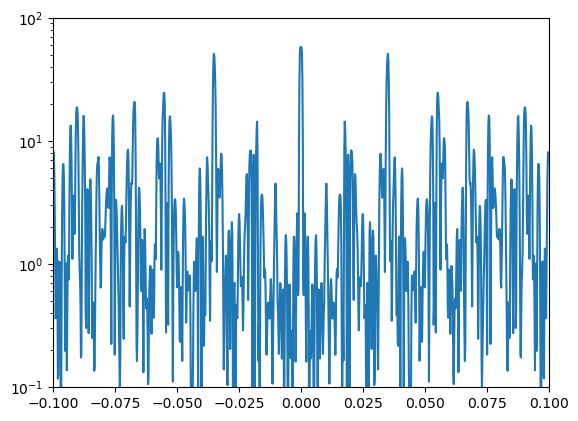

In [11]:
# Lomb-Scargle (full data) of Hipparcos
plt.figure()
freq, specwin = LombScargle(bjd_full - bjd_full[0], np.ones(len(bjd_full)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)
plt.ylim(1e-1, 100)

(-0.1, 0.1)

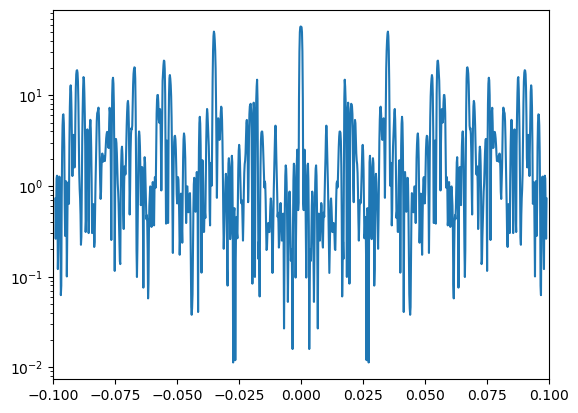

In [12]:
# Lomb-Scargle (clipped data) of Hipparcos
plt.figure()
freq, specwin = LombScargle(bjd - bjd[0], np.ones(len(bjd)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)

(0.0, 0.25)

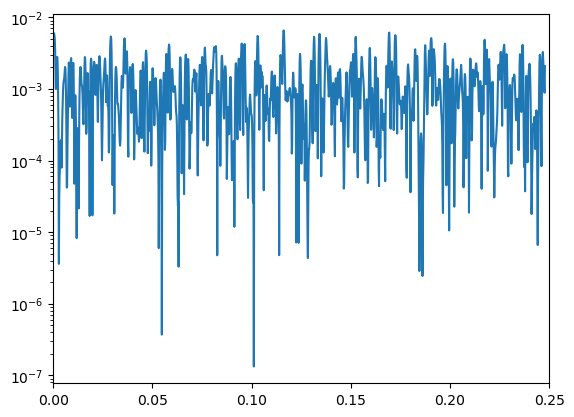

In [13]:
# Periodogram of Hipparcos data
plt.figure()
cut_frequency, cut_power = LombScargle(bjd - bjd[0], mag, normalization="psd").autopower()
plt.semilogy(cut_frequency, cut_power)
plt.xlim(0, 0.25)

(-0.1, 0.1)

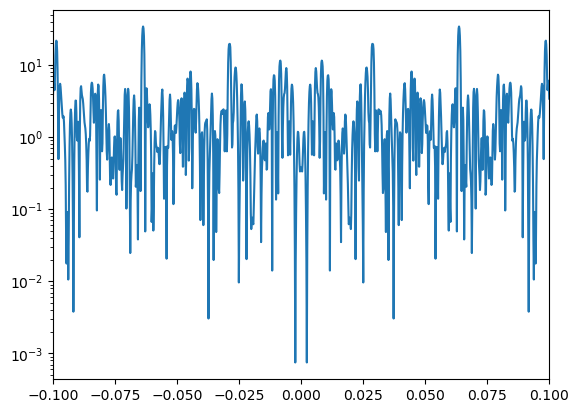

In [14]:
# Pesudo-window (unclipped) of Hipparcos
plt.figure()
freq, specwin = LombScargle(bjd_full - bjd_full[0], np.sin(2*np.pi*(bjd_full-bjd_full[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)

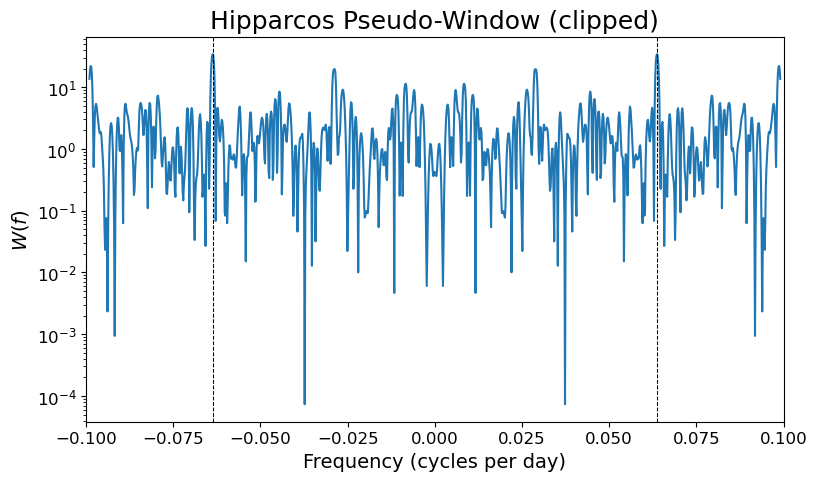

In [15]:
# Pseudo-Window for clipped data
plt.figure(figsize=(9, 5))
plt.title("Hipparcos Pseudo-Window (clipped)", fontsize=title_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
freq, specwin = LombScargle(bjd - bjd[0], np.sin(2*np.pi*(bjd-bjd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline(-(1/rp), linestyle='--', linewidth=0.75, color='black')

In [16]:
# Run speactral and psudeo window of Hipparcos data
# find wave length coverage of the filters of test filter (MAST), SuperWASP filter, and Hipparcos (Hp filter)
# add shaded resoulution to hipparcos
# for later, detrend Hipparcos.
# look at observation period for TESS, Hipparcos, and SuperWASP.